In [92]:
# !python -m spacy download en_core_web_sm -q

In [93]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import en_core_web_sm

import wordcloud

nlp = en_core_web_sm.load()

In [94]:
df = pd.read_csv('sample-data.csv')
#df = df.drop('id',axis=1)

pd.set_option('display.max_colwidth', False)

df.description

0      Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<

### Preprocessing

In [95]:
df['clean_description'] = df['description'].str.replace(r'<[^>]*>', '', regex=True) #Balise HTML
df["clean_description"] = df["clean_description"].str.replace(r"[^A-Za-z ]+", " ", regex = True) # Garder que les lettres
df['clean_description'] = df['clean_description'].fillna('').apply(lambda x: x.lower()) # Minuscule

df.head(2)

id  \
0  1    
1  2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><br>Made in Mexico.                                                  
1  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Program"<br><br><b>Weight: </b>(60 g 2.1 oz)<br><br>Made in Israel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### Tokenization

In [96]:
tokenized_desc = df['clean_description'].fillna('').apply(lambda x: nlp(x))
tokenized_desc = tokenized_desc.apply(lambda doc: [token.lemma_ for token in doc if token.text not in STOP_WORDS])

df["clean_token"] = tokenized_desc.apply(lambda x: ' '.join(x))

df.head(2)

id  \
0  1    
1  2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><br>Made in Mexico.                                                  
1  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Program"<br><br><b>Weight: </b>(60 g 2.1 oz)<br><br>Made in Israel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [97]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(500, 3626))

In [98]:
vectorizer.vocabulary_

{'active': 24,
 'classic': 520,
 'boxer': 337,
 'reason': 2441,
 'cult': 738,
 'favorite': 1110,
 'cool': 660,
 'especially': 1037,
 'sticky': 2973,
 'situation': 2793,
 'quick': 2402,
 'dry': 924,
 'lightweight': 1757,
 'underwear': 3358,
 'minimal': 1936,
 'space': 2894,
 'travel': 3275,
 'pack': 2148,
 'expose': 1069,
 'brush': 368,
 'waistband': 3477,
 'offer': 2085,
 'skin': 2805,
 'softness': 2874,
 'panel': 2168,
 'construction': 637,
 'traditional': 3257,
 'fit': 1156,
 'functional': 1265,
 'fly': 1201,
 'oz': 2145,
 'recycle': 2450,
 'polyester': 2296,
 'moisture': 1961,
 'wicke': 3558,
 'performance': 2222,
 'inseam': 1583,
 'size': 2794,
 'recyclable': 2449,
 'common': 593,
 'thread': 3191,
 'program': 2352,
 'silky': 2772,
 'capilene': 427,
 'fabric': 1086,
 'ultralight': 3338,
 'breathable': 346,
 'elastic': 970,
 'comfort': 583,
 'gladiodor': 1308,
 'natural': 2010,
 'odor': 2084,
 'control': 651,
 'garment': 1281,
 'programweight': 2354,
 'mexico': 1906,
 'sport': 2919,


In [99]:
vectorizer.get_feature_names_out()

array(['abandon', 'ability', 'able', ..., 'zipping', 'zips', 'zone'],
      shape=(3626,), dtype=object)

## Part 1 : Groups of products with similar descriptions

In [100]:
data = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names_out()])

data.head()

abandon  ability  able  abrasion  abrasive  abroad  absolute  absorb  \
0  0.0      0.0      0.0   0.0       0.0       0.0     0.0       0.0      
1  0.0      0.0      0.0   0.0       0.0       0.0     0.0       0.0      
2  0.0      0.0      0.0   0.0       0.0       0.0     0.0       0.0      
3  0.0      0.0      0.0   0.0       0.0       0.0     0.0       0.0      
4  0.0      0.0      0.0   0.0       0.0       0.0     0.0       0.0      

   absorption  abstract  ...  young  yvon  zinger  zip    zipper  zippered  \
0  0.0         0.0       ...  0.0    0.0   0.0     0.0  0.000000  0.000000   
1  0.0         0.0       ...  0.0    0.0   0.0     0.0  0.000000  0.000000   
2  0.0         0.0       ...  0.0    0.0   0.0     0.0  0.000000  0.000000   
3  0.0         0.0       ...  0.0    0.0   0.0     0.0  0.199243  0.121822   
4  0.0         0.0       ...  0.0    0.0   0.0     0.0  0.145095  0.000000   

   zippersfabric  zipping  zips  zone  
0  0.0            0.0      0.0   0.0   
1  0.0            0.0      0.0   0.0   
2  0.0            0.0      0.0   0.0   
3  0.0            0.0      0.0   0.0   
4  0.0            0.0      0.0   0.0   

[5 rows x 3626 columns]

In [101]:
k = 4

nn = NearestNeighbors(n_neighbors = k)
neighbors = nn.fit(data)

distances, _ = neighbors.kneighbors(data)
distances = np.sort(distances[:, k-1])

px.line(distances)

In [102]:
db = DBSCAN(eps=0.59, min_samples=6, metric="cosine", algorithm="brute")
db.fit(data)

DBSCAN(algorithm='brute', eps=0.59, metric='cosine', min_samples=6)

In [103]:
print(np.unique(db.labels_))
len(np.unique(db.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


15

In [104]:
df["Cluster_DBSCAN"] = pd.Series(db.labels_)
df.head(2)

id  \
0  1    
1  2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><br>Made in Mexico.                                                  
1  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Program"<br><br><b>Weight: </b>(60 g 2.1 oz)<br><br>Made in Israel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [105]:
df[df['Cluster_DBSCAN'] == 10].head(2)

id  \
4   5    
95  96   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       description  \
4   Alpine wind jkt - On high ridges, steep ice and anything alpine, this jacket serves as a true "best of all worlds" staple. It excels as a stand-alone shell for blustery rock climbs, cool-weather trail runs and high-output ski tours. And then, when conditions have you ice and alpine climbing, it functions as a lightly insulated windshirt on the approach, as well as a frictionless midlayer when it's time to bundle up and tie-in. The polyester ripstop shell with a Deluge DWR (durable water repellent) treatment sheds snow and blocks wind, while the smooth, lightly brushed hanging mesh liner wicks moisture, dries fast, and doesn't bind to your baselayers. Superlight stretch-woven underarm panels enhance breathability and allow for unimpaired arm motion, and the two hand pockets close with zippers. A drawcord hem, elastic cuffs, a heat-transfer reflective logo and a regular-coil, center-front zipper with DWR finish round out the features. Updated this season for an improved fit. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Lightweight, breathable polyester ripstop fabric with Deluge DWR (durable water repellent) finish; Slightly brushed polyester-mesh liner wicks moisture and dries fast"</li> <li>"Stretch-woven underarm panels provide breathability, stretch for unimpeded range of motion"</li> <li>DWR finish on center-front zipper</li> <li>Elastic cuffs</li> <li>"Pockets: exterior chest, zippered handwarmers"</li> <li>Drawcord hem</li> <li>Reflective heat-transfer logo</li></ul><br><br><b>Fabric: </b>Shell: 1.3-oz 20-denier 100% polyester ripstop. Panels: 4.6-oz 75-denier 90% all-recycled polyester/10% spandex. Shell and panels have Deluge DWR (durable water repellent) finish. Lining: 100% polyester brushed tricot mesh. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(331 g 11.5 oz)<br><br>Made in China.   
95  Nine trails jkt - Somewhere between the Bridger Ridge Run (for normal trail-runners) and the Barkley Marathons (for the insane), we all find our stri

In [106]:
wd = wordcloud.WordCloud(background_color="white", contour_width=1, contour_color='steelblue')

In [107]:
def get_doc_by_dataframe(df):
    stripped_corpus = [text.strip() for text in df["clean_description"]]

    clean_corpus = " ".join(stripped_corpus)

    return nlp(clean_corpus)

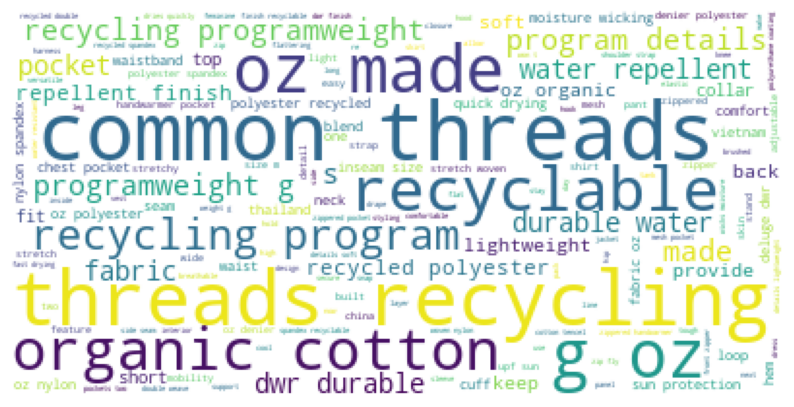

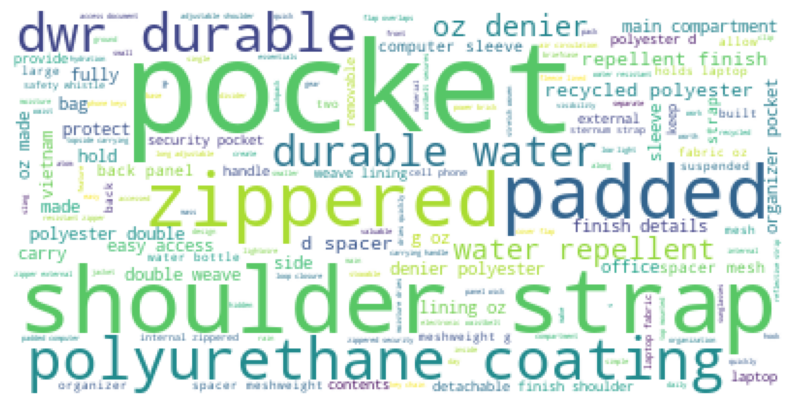

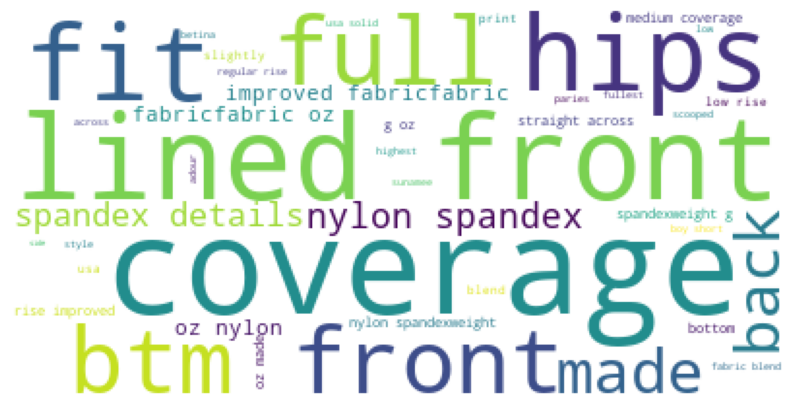

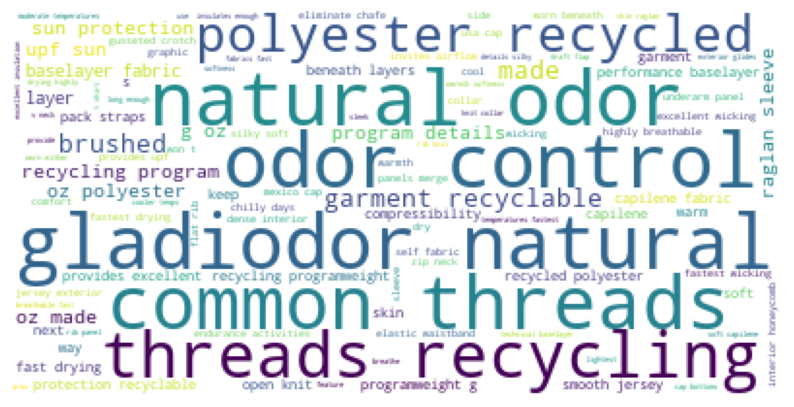

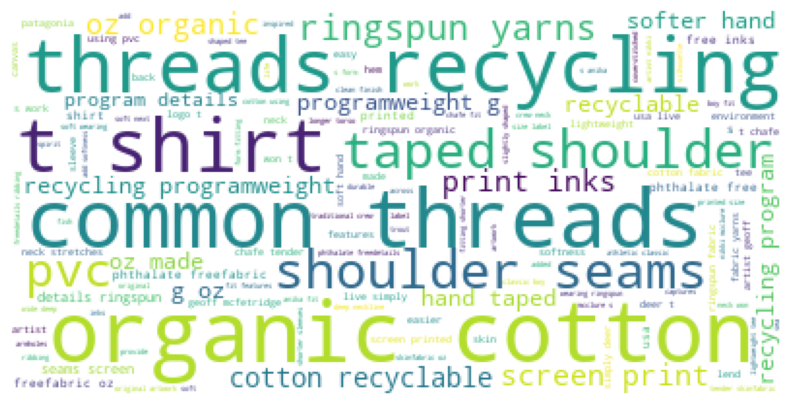

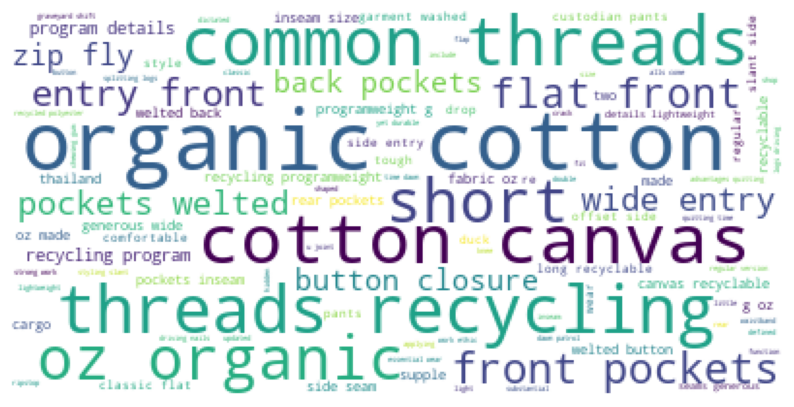

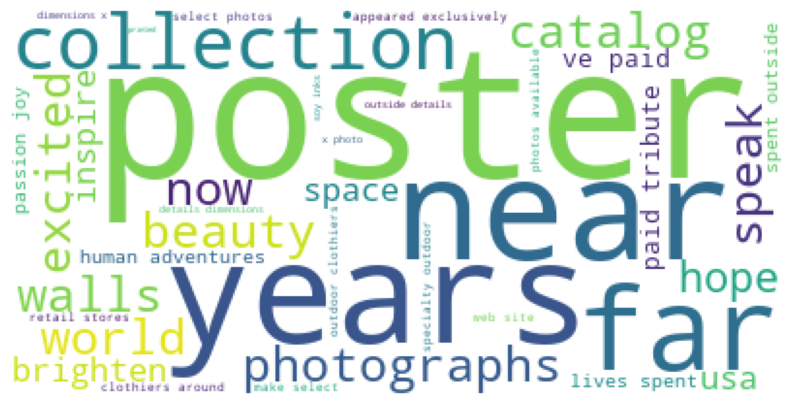

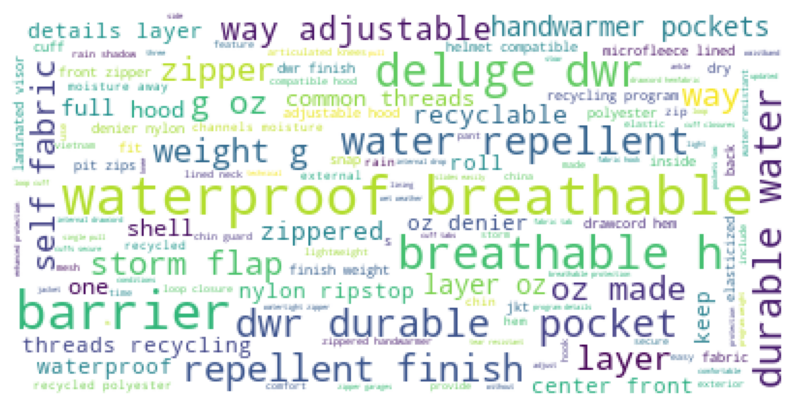

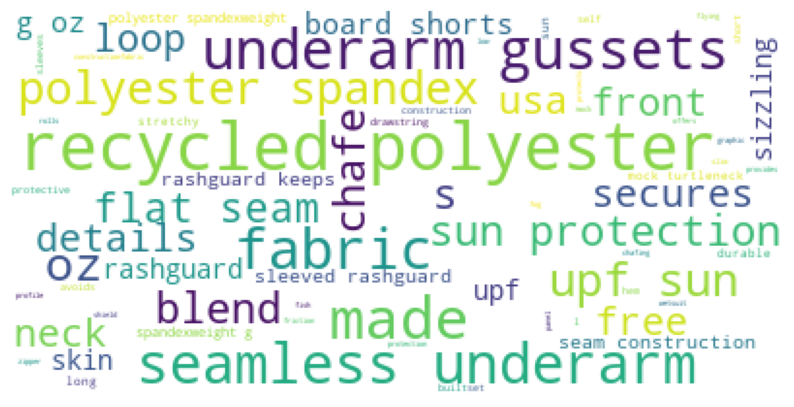

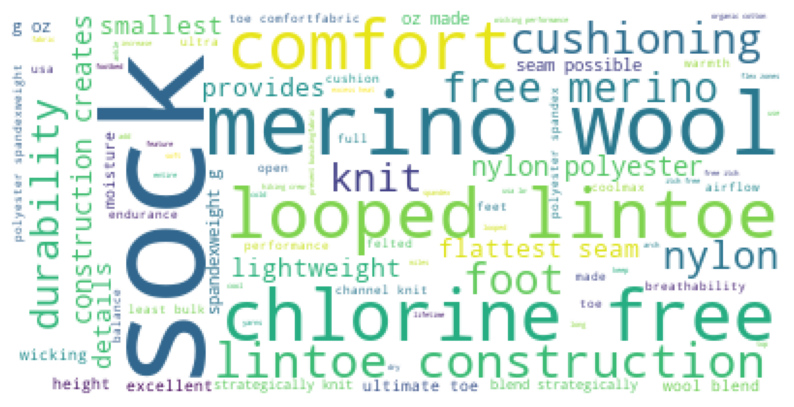

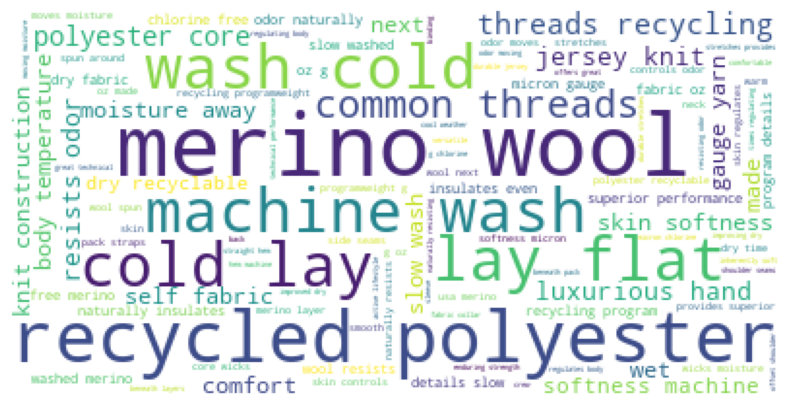

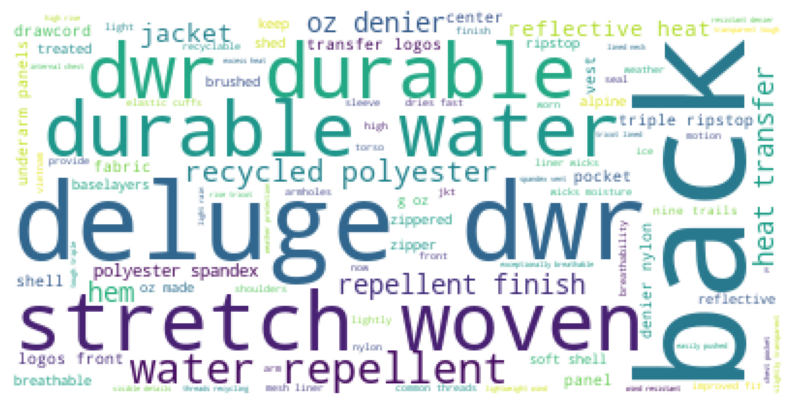

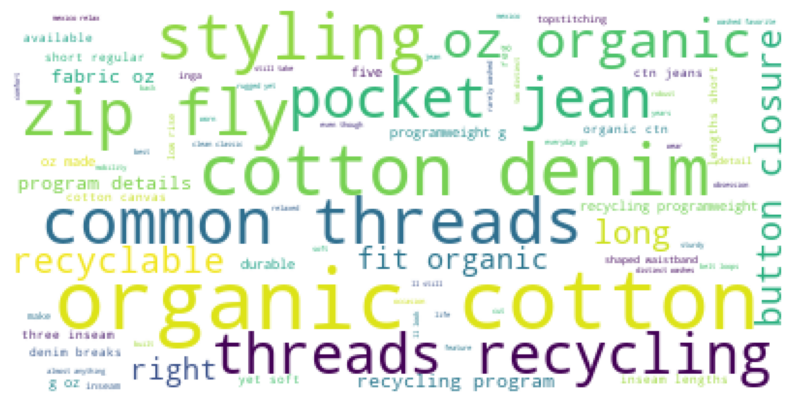

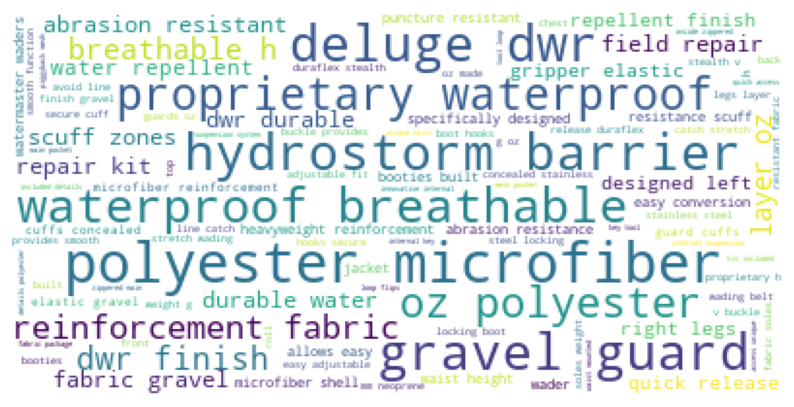

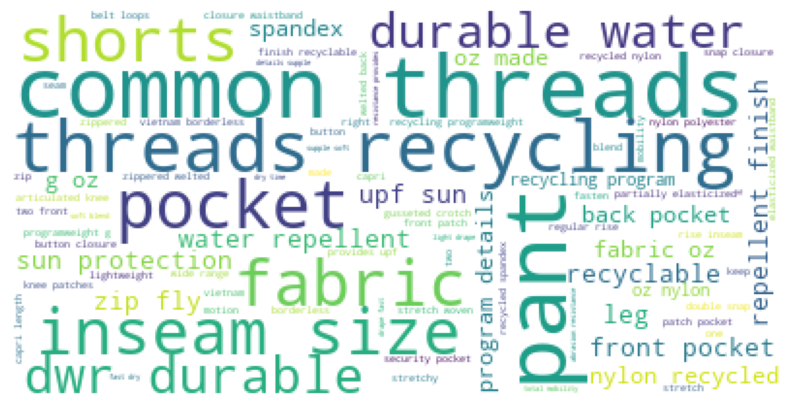

In [ ]:
for i in np.unique(db.labels_):
    df_tmp = df[df['Cluster_DBSCAN'] == i]

    doc = get_doc_by_dataframe(df_tmp)

    cloud = wd.generate(doc.text)

    # Show plot
    plt.figure(figsize = (10, 20))
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()


## Part 2 - Recommender system

In [109]:
def find_similar_items (item_id: int, nb_product: int) -> pd.core.frame.DataFrame:
    similar_items  = df[df['id'] == item_id]['Cluster_DBSCAN']
    
    # Vérifier si le DataFrame résultant est vide
    if similar_items .empty:
        print(f"Aucun item trouvé pour le cluster {item_id}.")
        return pd.DataFrame()

    df_cluster = df[df['Cluster_DBSCAN'] == similar_items.values[0]]
    return df_cluster['description'].sample(nb_product)

In [110]:

find_similar_items(3333, 5)

Aucun item trouvé pour le cluster 3333.


Empty DataFrame
Columns: []
Index: []

In [111]:
# Demander à l'utilisateur de choisir un produit
item_id = int(input("Entrez l'ID du produit pour obtenir des recommandations : "))

similar_items = find_similar_items(item_id, 5)

print(f"Produits similaires à l'item {item_id} : {similar_items}")

Produits similaires à l'item 1 : 309    Astrid top - The delicately feminine Astrid Top is a refreshing change from the heavy-lipped poundings of a big south swell. Made from our lightest weight blend of organic cotton and Tencel jersey (55%/45%) fabric, the short-sleeved top has a gathered scoop neck for a flattering fit and drape. The ultrasoft shirt falls at the hip. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Our lightest weight organic cotton and Tencel blend</li> <li>Short-sleeved top with flattering scoop neck</li> <li>Gathers at neck for fit and drape</li> <li>Hip length</li></ul><br><br><b>Fabric: </b>4-oz 55% organic cotton/45% Tencel jersey. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(109 g 3.8 oz)<br><br>Made in Thailand.                                                                                                                             
317    Barely hipster - The Barely Hipster's form-fi

## Part 3 : Topic modeling

In [140]:
n_components = 15

svd_model = TruncatedSVD(n_components = n_components, n_iter = 100, random_state = 122)
lsa = svd_model.fit_transform(X)

In [141]:
topic_encoded_df = pd.DataFrame(lsa, columns=[f'Topic_{i+1}' for i in range(n_components)])
topic_encoded_df

Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6   Topic_7  \
0    0.277514 -0.045577  0.185567  0.100521 -0.116297  0.016654 -0.075952   
1    0.299393 -0.066591  0.099559  0.115755 -0.025129  0.136128 -0.005725   
2    0.286435 -0.082810  0.109766  0.029172 -0.029017  0.100999  0.083672   
3    0.422879 -0.259293 -0.123417 -0.155411  0.036985 -0.022671 -0.061107   
4    0.405215 -0.266466 -0.025599 -0.249687 -0.035601 -0.073429  0.018938   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.335513 -0.072511  0.385250  0.081816 -0.257309 -0.022437 -0.141154   
496  0.370688 -0.072519  0.484438  0.001257 -0.309885 -0.059897 -0.077585   
497  0.338627 -0.211607 -0.049012 -0.236012 -0.004554 -0.193778  0.033797   
498  0.336917  0.078359 -0.141107  0.354138  0.039869 -0.088614 -0.182071   
499  0.382471  0.072186 -0.190771  0.368047  0.040374 -0.101330 -0.175016   

      Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  Topic_14  \
0   -0.010777 -0.127839 -0.085114 -0.012548  0.026015 -0.067531  0.020364   
1   -0.016877 -0.069367 -0.114981 -0.037629  0.104533 -0.101932  0.038793   
2    0.053402 -0.045821 -0.046319 -0.025480  0.152556 -0.089513  0.048756   
3   -0.111767  0.025512 -0.152475 -0.015035 -0.032336 -0.186319 -0.086907   
4    0.015525  0.118770 -0.148782 -0.002491 -0.113621 -0.227930  0.251178   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.079767 -0.303172 -0.142900 -0.051265 -0.032365 -0.047719  0.006487   
496  0.014425 -0.263817 -0.029377 -0.041772 -0.153767 -0.011737  0.104934   
497 -0.173002  0.035765  0.074615  0.029678 -0.001909  0.123410 -0.006822   
498  0.047969 -0.056672  0.034525 -0.015970 -0.041449  0.143163  0.140834   
499  0.048242 -0.025941  0.026622 -0.010629 -0.044121  0.120797  0.115613   

     Topic_15  
0    0.010912  
1   -0.093565  
2   -0.090983  
3   -0.024817  
4    0.053611  
..        ...  
495 -0.029486  
496 -0.031719  
497  0.028200  
498 -0.049225  
499 -0.008150  

[500 rows x 15 columns]

In [142]:
df['Main_Topic'] = topic_encoded_df.idxmax(axis=1)
df.head(2)

id  \
0  1    
1  2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              description  \
0  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><br>Made in Mexico.                                                  
1  Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that's fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won't roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Program"<br><br><b>Weight: </b>(60 g 2.1 oz)<br><br>Made in Israel.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

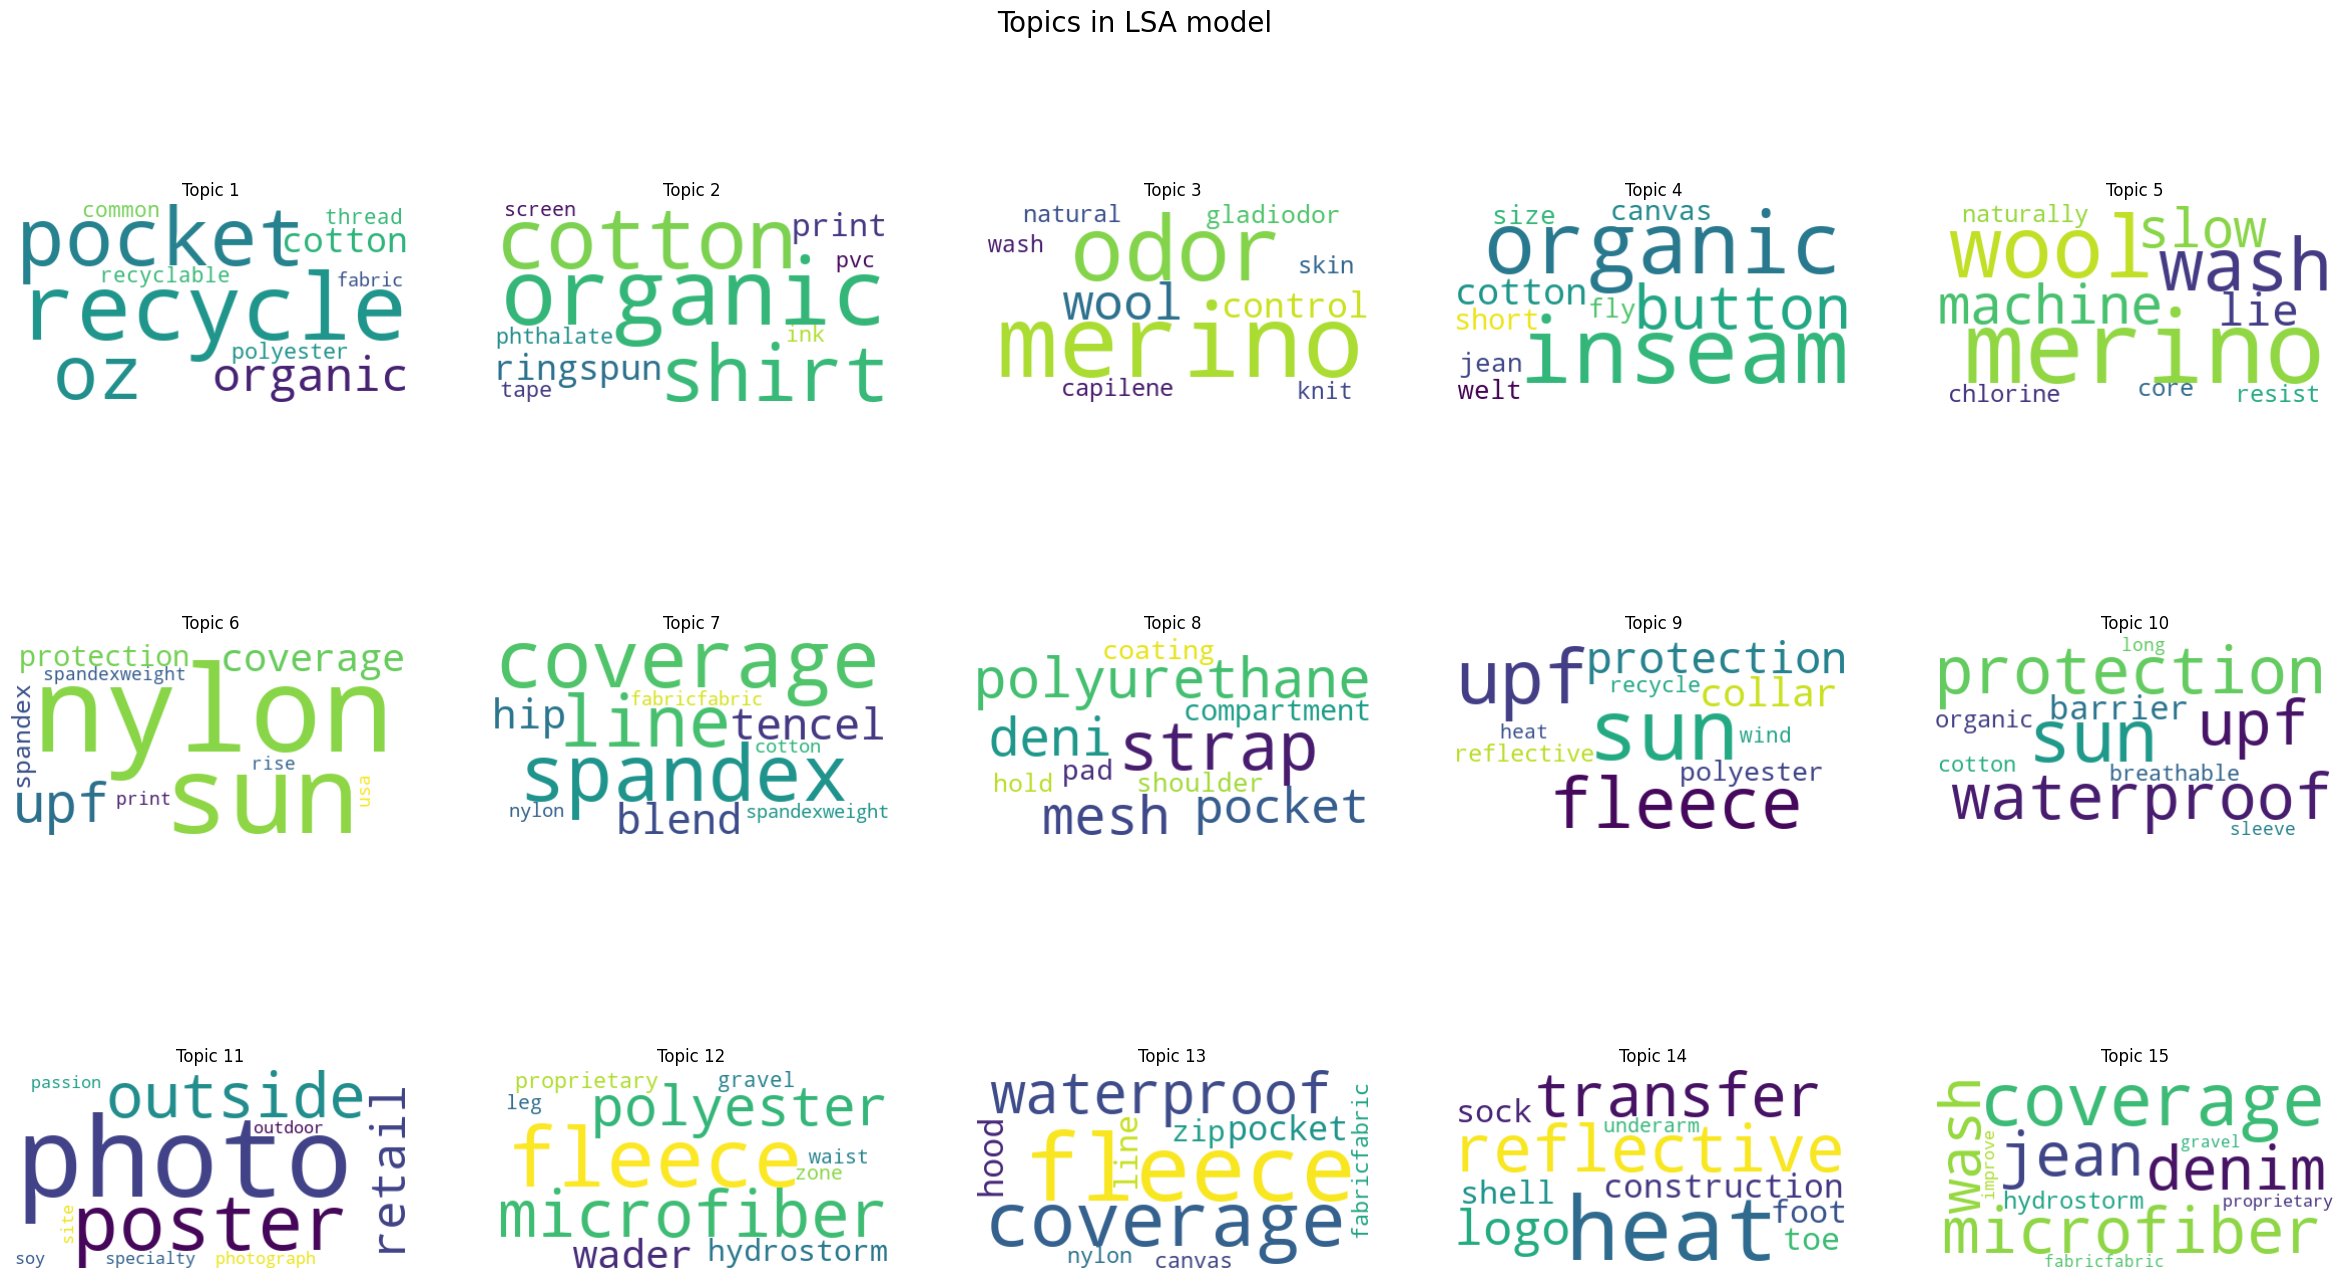

In [ ]:
# Étape 4 : Visualiser les sujets avec des nuages de mots
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize = (30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        wd = wordcloud.WordCloud(background_color = 'white').generate_from_frequencies(dict(zip(top_features, weights)))

        axes[topic_idx].imshow(wd, interpolation='bilinear')
        axes[topic_idx].axis('off')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}')

    plt.subplots_adjust(hspace = 0.5)
    plt.suptitle(title, fontsize = 20)
    plt.show()

# Nombre de mots principaux à afficher pour chaque sujet
n_top_words = 10
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(svd_model, tfidf_feature_names, n_top_words, 'Topics in LSA model')